In [14]:
import pandas as pd

# Load datasets
insiders_df = pd.read_csv('../../data/insiders_downloaded.csv')
cpv_df = pd.read_csv('cpv.csv', delimiter='|', header=None, names=['CPV', 'Description'])


change this and use preprocessed data directly

In [15]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy

# Load spaCy's Spanish language model
nlp = spacy.load('es_core_news_sm')

# Download NLTK stop words
nltk.download('stopwords')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define Spanish stop words
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text, language='spanish')
    
    # Remove unnecessary information (personal information, days, months)
    tokens = [re.sub(r'\b\d{2,}\b|(?:\d{1,2}[\/\-\.]){2,}\d{2,4}|\b(?:tel|email)\b', '', token) for token in tokens]
    tokens = [token for token in tokens if token.lower() not in ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo', 'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]
    
    # Remove non-alphabetic characters
    tokens = [re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ]', '', token) for token in tokens]
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in spanish_stopwords]
    
    # Lemmatization
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

# Apply preprocessing to the CPV descriptions
cpv_df['Description'] = cpv_df['Description'].apply(preprocess_text)

In [19]:
# Create a dictionary for CPV code to description mapping
cpv_map = pd.Series(cpv_df.Description.values, index=cpv_df.CPV).to_dict()

# Function to parse CPV codes from the string format and map them to descriptions
def map_cpv_to_description(cpv_string, cpv_map):
    cpv_string = cpv_string.strip('[]')  # Remove the brackets
    cpv_codes = cpv_string.split('.')    # Split by dots
    descriptions = [cpv_map.get(code.strip()) for code in cpv_codes if cpv_map.get(code.strip())]
    return descriptions

# Map CPV codes to descriptions in insiders_df
insiders_df['CPV_Descriptions'] = insiders_df['CPV'].apply(lambda x: '. '.join(map_cpv_to_description(x, cpv_map)))

In [20]:
# Load a pretrained sentence transformer model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generate embeddings for CPV descriptions
cpv_descriptions = insiders_df['CPV_Descriptions'].dropna().tolist()
cpv_embeddings = model.encode(cpv_descriptions, show_progress_bar=True)

Batches: 100%|██████████| 1919/1919 [08:47<00:00,  3.64it/s]


In [21]:
insiders_df.head(5)

,Unnamed: 0,id,zip,file name,entry,Description,CPV,URI,CPV_Descriptions
0,0.0,0,licitacionesPerfilesContratanteCompleto3_2018.zip,licitacionesPerfilesContratanteCompleto3_20200...,425,Contratación del servicio de limpieza en los C...,[90911200.],https://contrataciondelestado.es/wps/wcm/conne...,servicio limpiecer edificio
1,1.0,1,licitacionesPerfilesContratanteCompleto3_2018.zip,licitacionesPerfilesContratanteCompleto3_20200...,419,Servicios de mantenimiento de las instalacione...,[50711000.],https://contrataciondelestado.es/wps/wcm/conne...,servicio reparación mantenimiento equipo eléct...
2,2.0,2,licitacionesPerfilesContratanteCompleto3_2018.zip,licitacionesPerfilesContratanteCompleto3_20200...,269,"enseñanza, cursos de natacion y actividades ac...",[92620000.],https://contrataciondelestado.es/wps/wcm/conne...,servicio relacionado deporte
3,3.0,3,licitacionesPerfilesContratanteCompleto3_2018.zip,licitacionesPerfilesContratanteCompleto3_20200...,232,Contratación del servicio de mantenimiento y r...,[50711000.],https://contrataciondelestado.es/wps/wcm/conne...,servicio reparación mantenimiento equipo eléct...
4,4.0,4,licitacionesPerfilesContratanteCompleto3_2018.zip,licitacionesPerfilesContratanteCompleto3_20200...,207,Dispensación de productos sanitarios de ortope...,[33180000.],https://contrataciondelestado.es/wps/wcm/conne...,asistencia funcional


### Kmeans

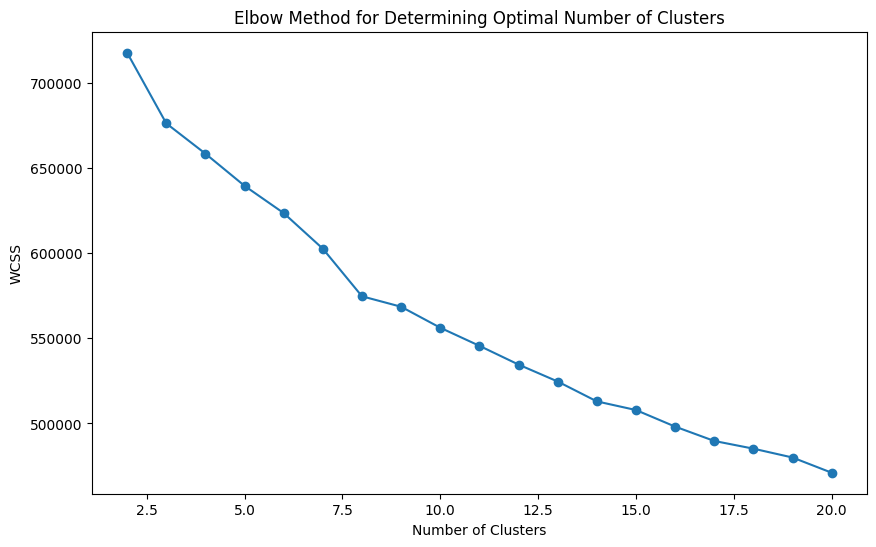

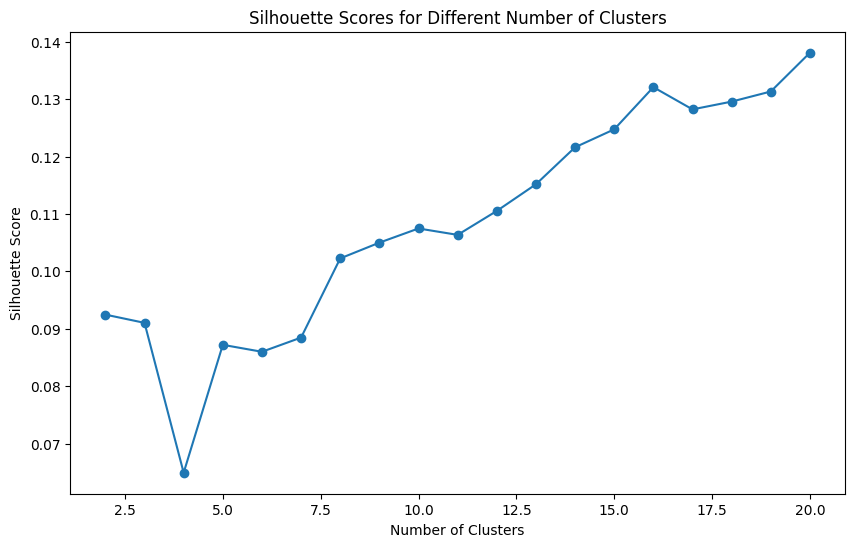

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate WCSS for different number of clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(cpv_embeddings)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(cpv_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


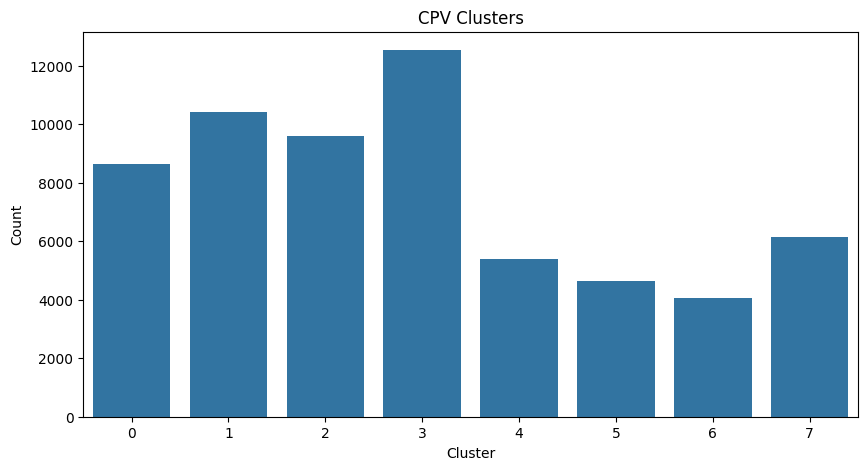

In [26]:
# Clustering CPV descriptions
from sklearn.cluster import KMeans
num_clusters = 8  # Adjust the number of clusters based on your data
kmeans_cpv = KMeans(n_clusters=num_clusters, random_state=0).fit(cpv_embeddings)
insiders_df['CPV_Cluster'] = kmeans_cpv.labels_

# Plot the distribution of CPV clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x='CPV_Cluster', data=insiders_df)
plt.title('CPV Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(cpv_embeddings)

# Add t-SNE results to the dataframe
insiders_df['tsne-2d-one'] = tsne_results[:,0]
insiders_df['tsne-2d-two'] = tsne_results[:,1]


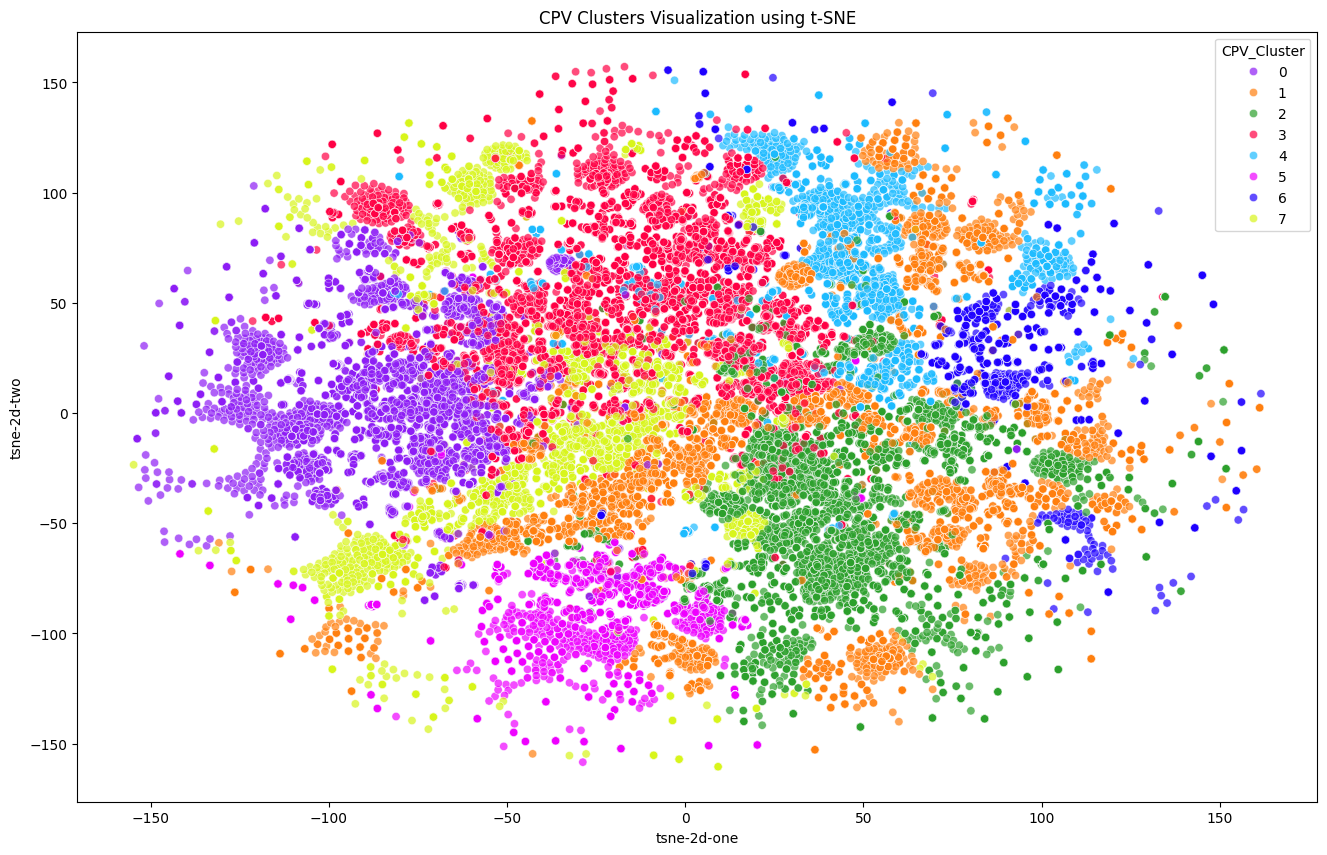

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your own color palette
custom_palette = {
    0: '#8d1df5',  
    1: '#ff7f0e',  
    2: '#2ca02c',  
    3: '#ff0044',  
    4: '#1cbbff', 
    5: '#ee00ff',  
    6: '#1e00ff', 
    7: '#d8f51b',  
}

# Plot the t-SNE results with the custom palette
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="CPV_Cluster",
    palette=custom_palette,
    data=insiders_df,
    legend="full",
    alpha=0.7
)
plt.title('CPV Clusters Visualization using t-SNE')
plt.show()


Analyze each cluster

In [39]:
from collections import Counter

def get_most_common_terms(cluster_descriptions, n=10):
    all_tokens = [token for description in cluster_descriptions for token in description.split()]
    most_common_terms = Counter(all_tokens).most_common(n)
    return most_common_terms

# Get most used terms for each cluster
for cluster in range(num_clusters):
    cluster_descriptions = insiders_df[insiders_df['CPV_Cluster'] == cluster]['CPV_Descriptions'].dropna().tolist()
    common_terms = get_most_common_terms(cluster_descriptions, n=10)
    print(f"Cluster {cluster}:")
    for term, count in common_terms:
        print(f"{term}: {count}")
    print("\n")



Cluster 0:
trabajo: 12675
construcción: 6933
pavimentación: 1717
instalación: 1647
obra: 1561
edificio: 1095
material: 1083
inmuebl: 1077
ingenieer: 869
construcción.: 826


Cluster 1:
servicio: 17715
seguro: 1504
transporte: 1462
social: 797
limpiecer: 719
mantenimiento: 709
limpieza: 646
desperdicio: 616
suministro: 579
relacionado: 566


Cluster 2:
servicio: 13665
software: 2886
consultoer: 1686
formación: 1605
desarrollo: 1558
sistema: 1412
gestión: 1360
paquete: 1349
consultorío: 1305
equipo: 946


Cluster 3:
equipo: 3525
instalación: 2926
trabajo: 2419
producto: 1866
servicio: 1688
aparato: 1678
material: 1594
alumbrado: 1015
artículo: 948
máquina: 946


Cluster 4:
servicio: 5446
publicidad: 974
deportivo: 873
cultural: 812
artístico: 777
esparcimiento: 669
organización: 635
exposición: 341
feria: 301
marketing: 297


Cluster 5:
servicio: 7235
ingeniería: 3659
arquitectura: 3657
construcción: 2289
inspección: 1164
proyecto: 1099
consultorío: 1064
diseño: 1015
elaboración: 821
pla